In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Introduction

In this chapter, we are going to explore how you can structure your data processing code, such that they are aware of what "valid" inputs look like.

## Schema Validation

The key idea we will be introducing here is "schema validation".

Before we go on, though, we should clarify some terms.

### Schemas

Firstly, what's a **schema**? From the [Wikipedia entry on database schemas](https://en.wikipedia.org/wiki/Database_schema):

> The database schema of a database is its structure described in a formal language supported by the database management system (DBMS). The term "schema" refers to the organization of data as a blueprint of how the database is constructed (divided into database tables in the case of relational databases).

For the purpose of this handbook, a schema can be described as:

> A declaration of what columns are expected to exist in a table: their names, data types, and valid ranges for each entry.

### Schema Validation

Next up, what about **schema validation**? Schema validation here refers to the act of checking that our data matches the schema that it is being checked against. This checking can be done for the input to a function and for the function's output too.

In other words, in our data processing functions, we check that the dataframe that we're handling follows the declared assumptions of what our data _ought_ to look like.

## When do we do schema validation?

Here are a few situations where schema validation is an important thing to do.

### At the data collection phase

If you're lucky, at the data collection phase, schema validation is already being performed, regardless of whether your data are being written to log files, added directly into a SQL database, or written in batches as parquet files. If your data are being written directly to a SQL database, then schema validation is already being performed, to the degree of stringency that the tables' columns are being specified!

### At the data transformation phase

If you're still lucky, a team of data engineers is helping you structure your data upstream of your use for analysis. Usually this means the data are being stored in a database, which has a SQL schema attached to it.

### At the analysis phase

Regardless of whether or not your data are being schema-fied upstream to when it gets to you, you should definitely take the time to walk carefully through the data and declare the expected schema that you need for your Python-based data processing functions.

This is the phase where you, the data scientist, can take action. In particular, I am going to show you the basics of how to declare pandas dataframe schemas using the Python package called `pandera`.

## DataFrame schemas with `pandera`

`pandera` is statistical validation package for pandas dataframes. Compared to alternatives that I have seen, `pandera` looks the most "natural" in its usage idioms. It is also very lightweight, focuses on doing one and only one thing well, and is very easily incorporated into a wide variety of data processing workflows.

Nothing beats learning by doing. As such, to help illustrate how to use `pandera`, I've designed an example that you can walk through to get a feel for how to use `pandera`. After that, there are a few more exercises that you can use to get more practice.

### Example: Declaring schemas with `pandera`

At the heart of `pandera` is the declaration of a dataframe schema.

Here is a plain text description of a dataframe we will be working with for this exercise, and its corresponding dataframe schema.

> Our dataframe has three columns:
> - `name`: a string column, with no nulls expected,
> - `age`: an integer column, positive only, nulls possibly present, but required for calculations,
> - `home_province`: a string column, and should be one of the 10 provinces or 3 territories of Canada, in its abbreviated form. Should not be null.

In [2]:
from pandera import Column, DataFrameSchema, Check
import pandera as pa

valid_provinces = ["AB", "BC", "MB", "NB", "NL", "NT", "NS", "NU", "ON", "PE", "QC", "SK", "YK"]

canadians_schema = DataFrameSchema(
    columns={
        "name": Column(pa.String, nullable=False),
        "age": Column(pa.Int, checks=[Check.greater_than(0)], nullable=True, required=True),
        "home_province": Column(pa.String, checks=[Check.isin(valid_provinces)], nullable=False)
    }
)

Now, let's say we have a function that accepts data of a bunch of Canadians,
and tries to calculate the mean age of individuals per province:

```python
def mean_age(df):
    return df.groupby("home_province").mean()
```

This function is one that we might consider "brittle", because there are no checks in the function that encode what we might expect to see for the dataframe `df`.

However, with `pandera`'s `check_input` decorator, we can validate the input data against the `canadians_schema` object.

In [3]:
from pandera import check_input
import pandas as pd

# `check_input` takes in a schema and a few other kwargs.
# lazy=True is a good default!
# Doing so will allow pandera to report _all_ failed checks.
@check_input(schema=canadians_schema, lazy=True)
def mean_age(df):
    return df.groupby("home_province").mean()

And then when fed _invalid_ Canadian data:

In [20]:
canadians_bad_data = pd.DataFrame({
    "age": [0, 10, 20, 30],
    "name": ["adrian", "becky", "charlie", "david"],
    "home_province": ["AB", "BC", "PEI", "NU"]
})


try:
    mean_age(canadians_bad_data)
except Exception as e:
    print(e)

A total of 2 schema errors were found.

Error Counts
------------
- schema_component_check: 2

Schema Error Summary
--------------------
                                                                                                                  failure_cases  n_failure_cases
schema_context column        check                                                                                                              
Column         age           greater_than(0)                                                                                [0]                1
               home_province isin({'NB', 'AB', 'NL', 'PE', 'SK', 'NT', 'YK', 'NS', 'BC', 'ON', 'QC', 'NU', 'MB'})         [PEI]                1

Usage Tip
---------

Directly inspect all errors by catching the exception:

```
try:
    schema.validate(dataframe, lazy=True)
except SchemaErrors as err:
    err.schema_errors  # dataframe of schema errors
    err.data  # invalid dataframe
```



_Voila!_ `pandera` told us exactly which row in the dataframe failed the schema check.
If this is the responsibility of our data provider,
we can now go and complain to them that the dataframe has errors,
and show them the error message.

On the other hand, if you have good data:

In [5]:
canadians_good_data = pd.DataFrame({
    "age": [5, 10, 20, 30],
    "name": ["adrian", "becky", "charlie", "david"],
    "home_province": ["AB", "BC", "PE", "NU"]
})

mean_age(canadians_good_data)

,age
home_province,
AB,5
BC,10
NU,30
PE,20


`pandera` doesn't error out, and instead lets the calculation proceed as per normal.

## `pandera` usage tips

Here's some tips that I have for using `pandera`.

### Store schemas in its own `.py` file

I usually store them in `src/data/schemas.py`, so that the Python object is importable later on, and I can use it anywhere in the project. If others are working on the same project and have the custom source package installed in their environment, then they'll have access to it as well.

### Use the default checks when possible

`pandera` comes with a [rich library of built-in checks](https://pandera.readthedocs.io/en/stable/generated/pandera.Check.html#pandera.Check). I'd recommend using these wherever possible.

### Custom checks can be implemented

If you so choose to, your custom checks can be implemented easily by writing a custom function that takes in a pandas Series and returns a boolean Series or a single boolean. For example, `Check.greater_than(0)` can also be expressed as `lambda s: s > 0`.

## Exercises with `pandera`

Now, it's your turn to get practice writing `pandera` schemas. Give it a shot using the following datasets and data preprocessing functions.

### Exercise: Boston data summarization

In this exercise, we are going to summarize data from the City of Boston.

In [6]:
from pyprojroot import here
import janitor

boston_data = pd.read_csv(here() / 'data/boston_ei.csv')
boston_data.head()

,Year,Month,logan_passengers,logan_intl_flights,hotel_occup_rate,hotel_avg_daily_rate,total_jobs,unemp_rate,labor_force_part_rate,pipeline_unit,pipeline_total_dev_cost,pipeline_sqft,pipeline_const_jobs,foreclosure_pet,foreclosure_deeds,med_housing_price,housing_sales_vol,new_housing_const_permits,new-affordable_housing_permits
0,2013,1,2019662,2986,0.572,158.925868,0,0.071,0.594,329,80000000,313107,241.600,44,11,380000,405,534,134
1,2013,2,1878731,2587,0.645,165.497062,0,0.063,0.591,557,360700000,1001911,1089.314,50,10,359500,332,196,13
2,2013,3,2469155,3250,0.819,187.450000,0,0.061,0.591,803,343200000,820556,1036.464,6,6,400000,479,12,0
3,2013,4,2551246,3408,0.855,233.435374,0,0.061,0.593,325,150000000,350000,453.000,14,8,403000,558,91,24
4,2013,5,2676291,3240,0.858,237.890210,0,0.069,0.597,122,222200000,457374,671.044,12,4,425500,809,63,0


Based on the [data description provided online](https://data.boston.gov/dataset/economic-indicators-legacy-portal/resource/15a516fc-6186-41c3-877e-b23135952c76), try your hand at translating it into a `pandera` DataFrame schema.

In [7]:
import warnings
warnings.filterwarnings("ignore")
from testing_tutorial.schemas import boston_schema

Now, we want to summarize the monthly trend of each of these, by calculating the mean over each month.

In [16]:
import math
import matplotlib.pyplot as plt
from sqdiv import n_rows_cols

@check_input(schema=boston_schema, lazy=True)
def plot_monthly_trend(df):
    columns_to_plot = set(df.columns).difference(["Year", "Month"])
    nrows, ncols = (3, 6)
    data = df.groupby("Month").mean()
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
    
    for column, ax in zip(columns_to_plot, axes.flatten()):
        ax.plot(data[column])
        ax.set_title(column)
    plt.tight_layout()

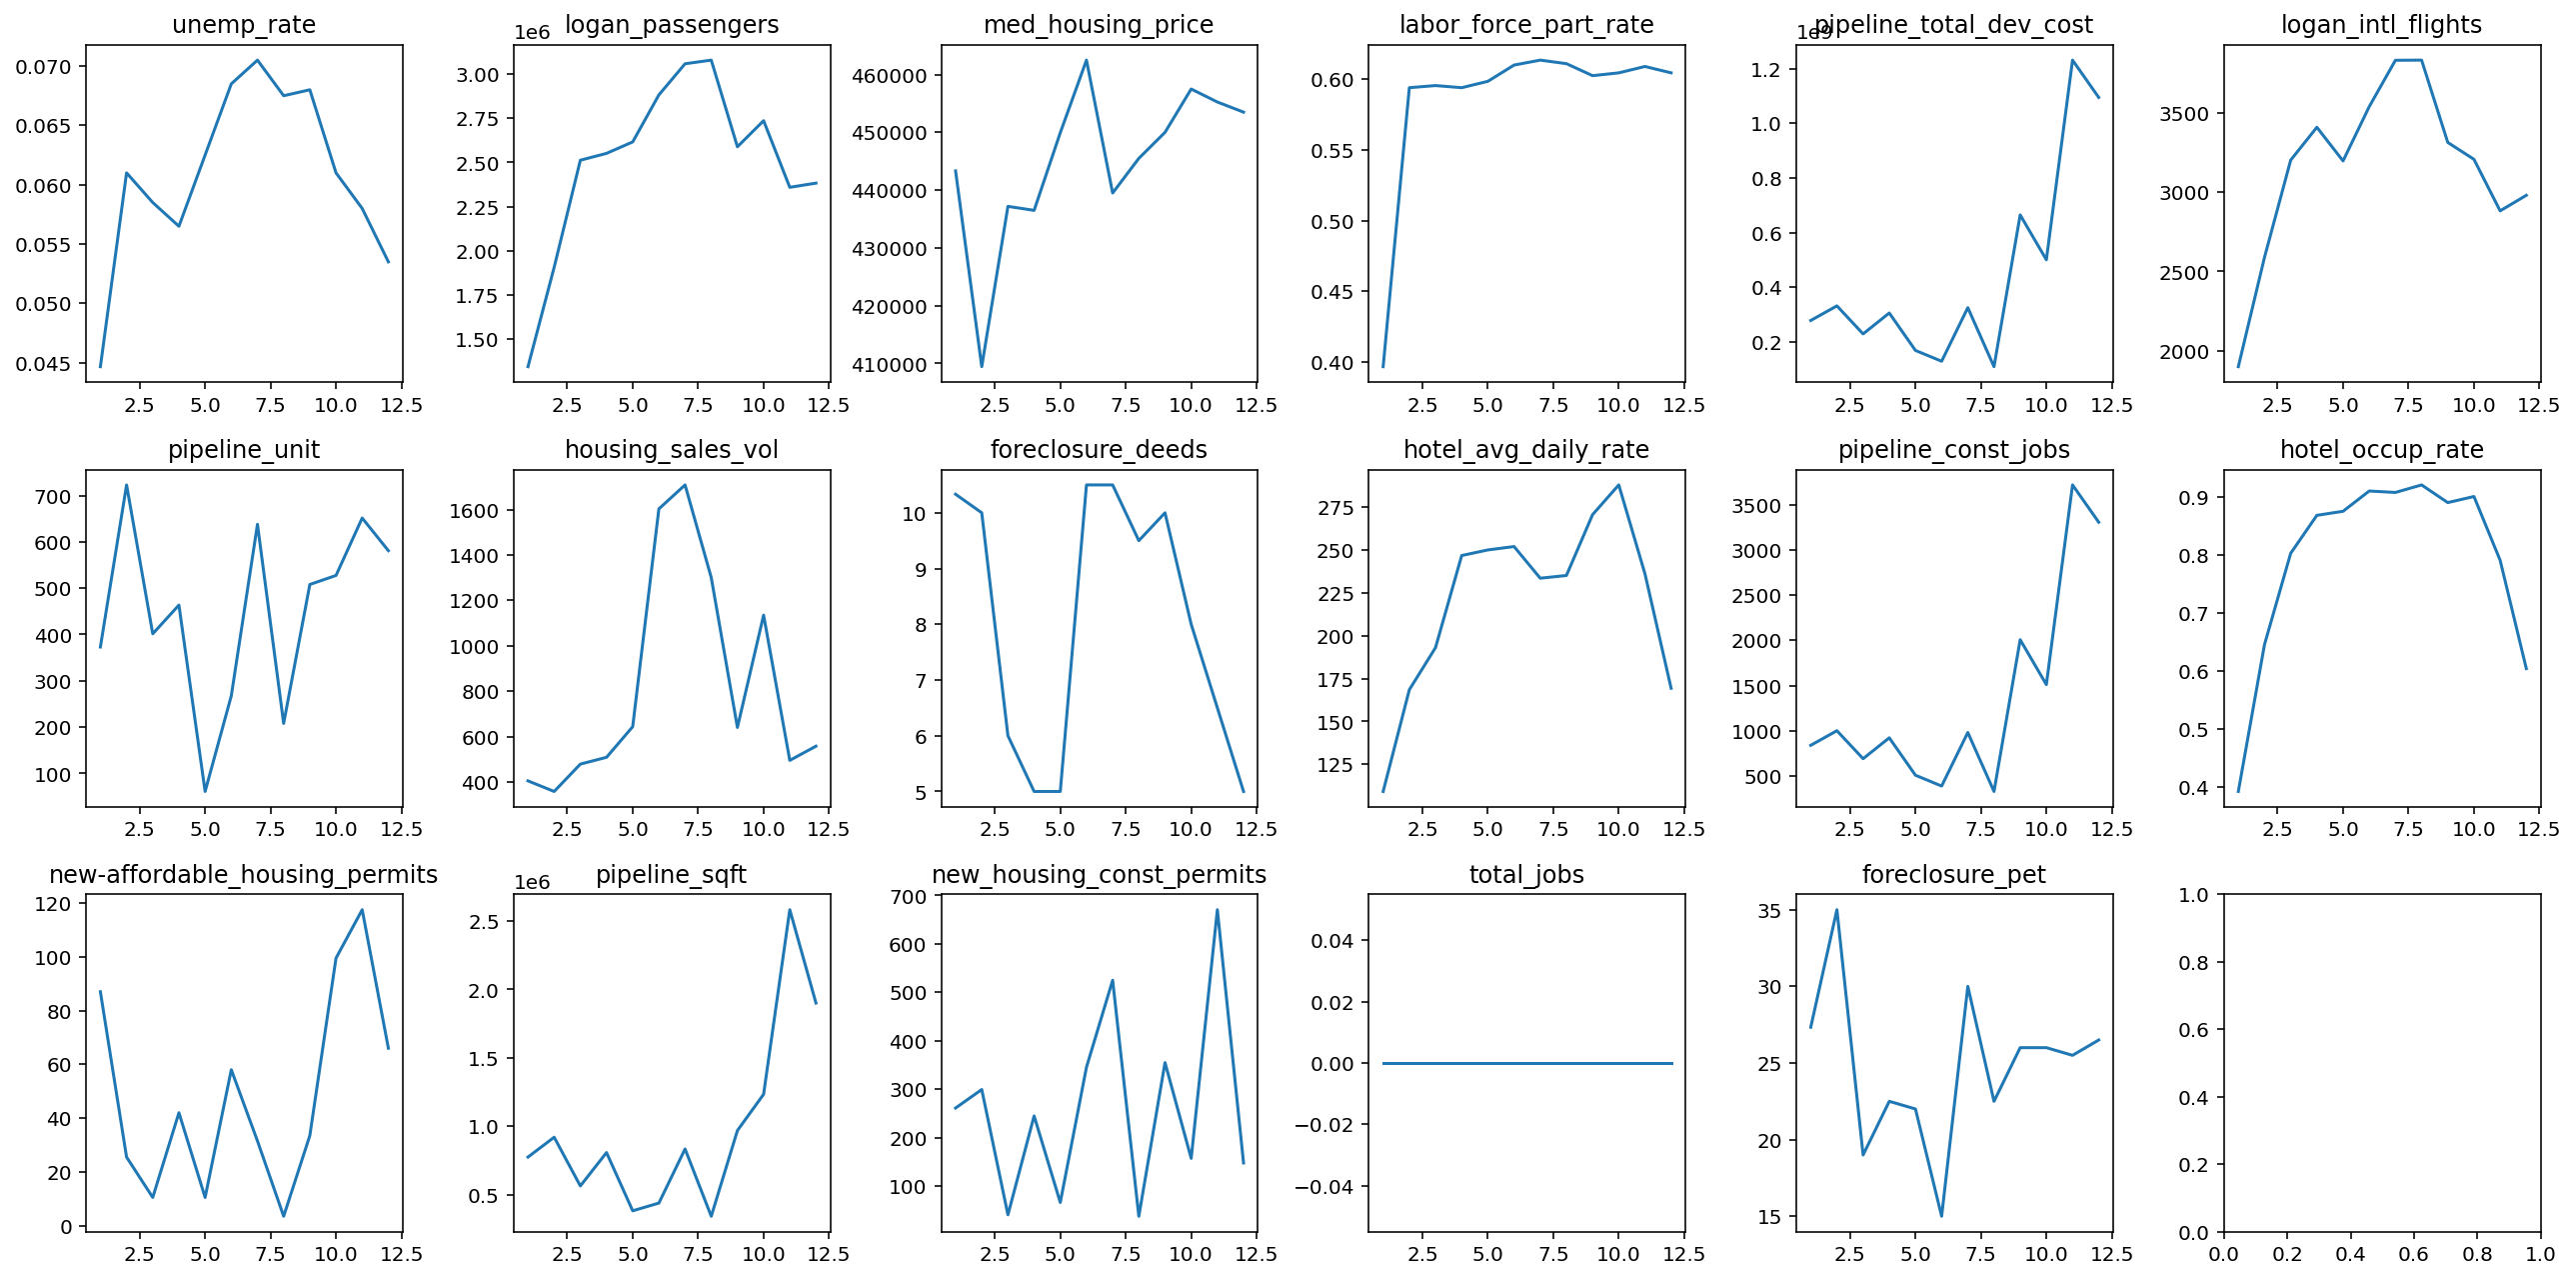

In [17]:
plot_monthly_trend(boston_data)

Now, try calling the plotting function with a corrupted version of the dataframe, and verify that there are errors showing up.

In [18]:
boston_data_corrupt = pd.read_csv(here() / "data/boston_ei-corrupt.csv")

In [19]:
plot_monthly_trend(boston_data_corrupt)

SchemaErrors: A total of 5 schema errors were found.

Error Counts
------------
- schema_component_check: 5

Schema Error Summary
--------------------
                                                                    failure_cases  n_failure_cases
schema_context column                check                                                        
Column         labor_force_part_rate not_nullable  [nan, nan, nan, nan, nan, nan]                6
               pipeline_const_jobs   not_nullable            [nan, nan, nan, nan]                4

Usage Tip
---------

Directly inspect all errors by catching the exception:

```
try:
    schema.validate(dataframe, lazy=True)
except SchemaErrors as err:
    err.schema_errors  # dataframe of schema errors
    err.data  # invalid dataframe
```


### Exercise: `pandera` schema for Divvy bike stations

Now, I'd like you to try out `pandera`'s ability to _infer_ a schema for you.

In [24]:
divvy = pd.read_csv(
    here() / "data/Divvy_Stations_2013.csv",  # there is a corrupt version: Divvy_Stations_2013_corrupt.csv
    parse_dates=["online date"],
    index_col="id"
).clean_names()
divvy

,name,latitude,longitude,dpcapacity,landmark,online_date
id,,,,,,
5,State St & Harrison St,41.873958,-87.627739,19,30,2013-06-28
13,Wilton Ave & Diversey Pkwy,41.932500,-87.652681,19,66,2013-06-28
14,Morgan St & 18th St,41.858086,-87.651073,15,163,2013-06-28
15,Racine Ave & 18th St,41.858181,-87.656487,15,164,2013-06-28
16,Wood St & North Ave,41.910329,-87.672516,15,223,2013-08-12
...,...,...,...,...,...,...
347,Ashland Ave & Grace St,41.950687,-87.668700,15,319,2013-10-12
348,California Ave & 21st St,41.854016,-87.695445,15,96,2013-10-14
349,Halsted St & Wrightwood Ave,41.929143,-87.649077,15,210,2013-10-28


Your ultimate goal here is to write a `pandera` schema for the Divvy bike station dataset, and place it in `src/testing_tutorial/student_schemas.py`.

However, before that, I wanted to introduce you to `pandera`'s ability to _infer_ schemas automatically.

In [29]:
from pandera import io

divvy_schema = pa.infer_schema(divvy)
schema_script = io.to_script(divvy_schema)
print(schema_script)

from pandas import Timestamp
from pandera import (
    DataFrameSchema,
    Column,
    Check,
    Index,
    MultiIndex,
    PandasDtype,
)

schema = DataFrameSchema(
    columns={
        "name": Column(
            pandas_dtype=PandasDtype.String, checks=None, nullable=False
        ),
        "latitude": Column(
            pandas_dtype=PandasDtype.Float64,
            checks=[
                Check.greater_than_or_equal_to(min_value=41.788746),
                Check.less_than_or_equal_to(max_value=41.978353000000006),
            ],
            nullable=False,
        ),
        "longitude": Column(
            pandas_dtype=PandasDtype.Float64,
            checks=[
                Check.greater_than_or_equal_to(min_value=-87.70785699999999),
                Check.less_than_or_equal_to(max_value=-87.580715),
            ],
            nullable=False,
        ),
        "dpcapacity": Column(
            pandas_dtype=PandasDtype.Int64,
            checks=[
                Check.great

The above can give you a convenient starting point for creating your own schema. Now, I'd like you to use that as a starting point and declare a `divvy_schema` object in `src/testing_tutorial/student_schemas.py`.
(If you're curious as to what I ended up declaring, you can inspect the source for the `divvy_schema` object in `src/testing_tutorial/schemas.py`.

## Conclusions

In the interest of keeping the handbook short, I have only given you a preview of how to use `pandera` for _runtime validation_ of your data. However, I hope some ideas have become clearer for you.

Firstly, by declaring your assumptions of the data up-front, you can create a single source of truth for what you _expect_ your data to look like. With `pandera`, you get an object that you can use around the project.

This leads to the second idea: By using `pandera`'s `check_input` (and its analogous `check_output` functions, you get runtime validation of your data functions. This can reduce the element of surprise when data that don't fit your assumptions break your data processing functions, or when they break your data processing pipeline in silent ways that propagate through the project.

Thirdly, though schema declaration seem like there's "yet another tool", or "yet more work to do", in this case, I can share with you with complete confidence that this extra work up-front pays multiple fold dividends in time saved and frustrations avoided. Just as tests are a source of truth for how a function is supposed to behave, schema declarations are a source of truth on how data are supposed to look. When two parties do not agree on what the data are supposed to look like, we can look to the schema. If the schema has previously passed code review, then there really ought to be no argument over it!